In [2]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [3]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 284807 samples in total but only 492 cases of fraud


### Feature Scaling

In [4]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[  3.91864870e-15   5.68268579e-16  -8.76173610e-15   2.81111774e-15
  -1.55210305e-15   2.04012968e-15  -1.69895265e-15  -1.95815061e-16
  -3.14764036e-15   1.77292451e-15   9.28952385e-16  -1.80326603e-15
   1.67488824e-15   1.47562122e-15   3.50109813e-15   1.39243845e-15
  -7.46653801e-16   4.25873794e-16   9.02016885e-16   5.12684532e-16
   1.47198194e-16   8.04210901e-16   5.28245009e-16   4.45826738e-15
   1.42689564e-15   1.70163965e-15  -3.67160561e-16  -1.21815215e-16
   8.83496193e+01]
[  3.83647578e+00   2.72681045e+00   2.29902117e+00   2.00467678e+00
   1.90507436e+00   1.77494002e+00   1.53039520e+00   1.42647385e+00
   1.20698823e+00   1.18558965e+00   1.04185143e+00   9.98399911e-01
   9.90567315e-01   9.18902320e-01   8.37800459e-01   7.67816427e-01
   7.21370915e-01   7.02536891e-01   6.62659610e-01   5.94323307e-01
   5.39523633e-01   5.26640906e-01   3.89949292e-01   3.66807083e-01
   2.71729873e-01   2.32542076e-01   1.62918619e-01   1.08954579e-01
   6.25598494e+

### Preliminary plotting

[ 1.19185711 -1.35835406 -0.96627171 -1.15823309 -0.42596588  1.22965763
 -0.64426944 -0.89428608 -0.33826175]


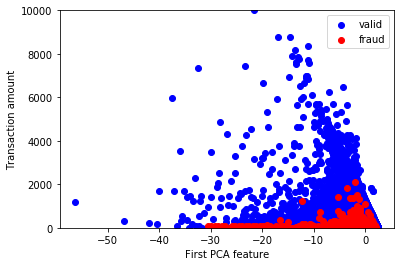

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[56826    37]
 [   43    56]]
Fold 1
[[56828    35]
 [   34    65]]
Fold 2
[[56833    30]
 [   34    64]]
Fold 3
[[56808    55]
 [   36    62]]
Fold 4
[[56824    39]
 [   31    67]]
Final Confusion Matrix
[[  5.68238000e+04   3.92000000e+01]
 [  3.56000000e+01   6.28000000e+01]]
False negatives (valid): 0.000689376220038
False positives (fraud): 0.361788617886


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[49053  7810]
 [    4    95]]
Fold 1
[[48482  8381]
 [    3    96]]
Fold 2
[[49870  6993]
 [    4    94]]
Fold 3
[[50381  6482]
 [    6    92]]
Fold 4
[[48856  8007]
 [    3    95]]
Final Confusion Matrix
[[  4.93284000e+04   7.53460000e+03]
 [  4.00000000e+00   9.44000000e+01]]
False negatives (valid): 0.132504440497
False positives (fraud): 0.0406504065041


#### Linear SVM with Scaling and Class Weights

In [21]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[33547 23316]
 [    1    98]]
Fold 1
[[34436 22427]
 [    0    99]]
Fold 2
[[34014 22849]
 [    0    98]]
Fold 3
[[34283 22580]
 [    1    97]]
Fold 4
[[33524 23339]
 [    2    96]]
Final Confusion Matrix
[[  3.39608000e+04   2.29022000e+04]
 [  8.00000000e-01   9.76000000e+01]]
False negatives (valid): 0.402761022106
False positives (fraud): 0.00813008130081


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data, scale=True, kernel='rbf');

In [ ]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

#### Polynomial Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data, scale=True, kernel='poly');

In [ ]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

### Logistic Regression

In [10]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        scaler = StandardScaler()
        train_data = scaler.fit_transform(np.delete(data, folds[i], axis=0))
        test_data = scaler.transform(data[folds[i]])
            
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(train_data, np.delete(labels, folds[i]))
        pred = model.predict(test_data)
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = model.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = model.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [11]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_logistic_regression(data, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000895333731259 Valid Error: 0.154863443716 Fraud Error 0.282828282828


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000842667041185 Valid Error: 0.205458734151 Fraud Error 0.212121212121


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000737346605572 Valid Error: 0.149464502401 Fraud Error 0.214285714286


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000877793578062 Valid Error: 0.184214691451 Fraud Error 0.275510204082


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.000877793578062 Valid Error: 0.234071364508 Fraud Error 0.15306122449
FINAL Error: 0.000846186906828 Valid Error: 0.185614547245 Fraud Error 0.227561327561
Checking class weight None and coefficient 0.016681005372000592


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000895333731259 Valid Error: 0.160104109878 Fraud Error 0.272727272727


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000842667041185 Valid Error: 0.224592441482 Fraud Error 0.212121212121


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000719790734011 Valid Error: 0.156921020699 Fraud Error 0.204081632653


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000877793578062 Valid Error: 0.196437050455 Fraud Error 0.275510204082


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.000895349449623 Valid Error: 0.268768795174 Fraud Error 0.112244897959
FINAL Error: 0.000846186906828 Valid Error: 0.201364683538 Fraud Error 0.215337043908
Checking class weight None and coefficient 0.027825594022071243


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.000895333731259 Valid Error: 0.170005099977 Fraud Error 0.262626262626


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.000842667041185 Valid Error: 0.244992350034 Fraud Error 0.212121212121


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000719790734011 Valid Error: 0.173539911718 Fraud Error 0.204081632653


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)